<a href="https://colab.research.google.com/github/arifpras/PredictingStock/blob/main/20240306_lstm02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras.models import load_model

# Load the LSTM model
model = load_model('/content/drive/MyDrive/01lstm/20240306_lstm01.h5')


In [4]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/01lstm/jci.xlsx', sheet_name='bbri')
df['price'] = df['price'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1229 non-null   datetime64[ns]
 1   price   1229 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.3 KB


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = df.price.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [6]:
import numpy as np

seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.9)


In [8]:
# Assuming X_test contains your test data
# Reshape the data to match the input shape of the LSTM model

x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [11]:
# Predict the future values
future_steps = 10  # Number of future steps to predict
future_predictions = []

# Use the last sequence from test data as a starting point for prediction
last_sequence = x_test_reshaped[-1]

for _ in range(future_steps):
    # Reshape the last sequence to match the model input shape
    last_sequence_reshaped = last_sequence.reshape((1, last_sequence.shape[0], 1))

    # Predict the next value
    next_prediction = model.predict(last_sequence_reshaped)[0][0]

    # Append the prediction to the list of predictions
    future_predictions.append(next_prediction)

    # Update the last sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], next_prediction)
    last_sequence = last_sequence.reshape((last_sequence.shape[0], 1))

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

1/1 [==============================] - 0s 39ms/step


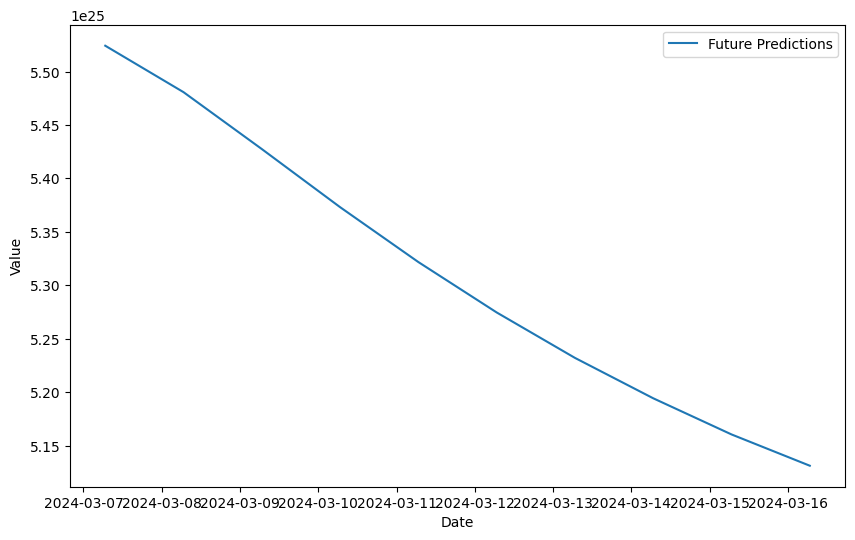

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Generate future dates for plotting
last_date = pd.Timestamp.now()  # Assuming the last date in your dataset is the current date
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='D')[1:]

# Enlarge the plot
plt.figure(figsize=(10, 6))

# Plot the predictions
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()